In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import os
import sys
from copy import deepcopy
import warnings

from pathlib import Path
import matplotlib.pyplot as plt
import napari

import scanreader

import pandas as pd
import numpy as np
import dask.array as da
import numpy as np
try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

import mesmerize_core as mc
from mesmerize_core.caiman_extensions.cnmf import cnmf_cache

from caiman.motion_correction import high_pass_filter_space
from caiman.summary_images import correlation_pnr


if os.name == "nt":
    # disable the cache on windows
    cnmf_cache.set_maxsize(0)

sys.path.append("../../scanreader/")
warnings.filterwarnings("ignore")
os.environ["CONDA_PREFIX_1"] = ""
os.environ["WGPU_BACKEND"]="gl"

pd.options.display.max_colwidth = 120

## Functions 
def clear_zeros(_scan, rmz_threshold=1e-5):
    non_zero_rows = ~np.all(np.abs(_scan) < rmz_threshold, axis=(0, 2))
    non_zero_cols = ~np.all(np.abs(_scan) < rmz_threshold, axis=(0, 1))
    cleaned = _scan[:, non_zero_rows, :]
    return cleaned[:, :, non_zero_cols]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2024-08-16 13:45:11.149172: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 13:45:11.149207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 13:45:11.149601: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### NOTE

on `cannot open libGL shared library`:

`sudo apt-get update && apt-get install ffmpeg libsm6 libxext6  -y`

### Set up data and save-paths

In [2]:
parent = Path('/home/mbo/caiman_data/high_res')

mc.set_parent_raw_data_path(parent / 'final')
process_path = mc.get_parent_raw_data_path()
batch_path = mc.get_parent_raw_data_path().joinpath("batch/reg")
save_path = mc.get_parent_raw_data_path().joinpath("results")
raw = [x for x in parent.glob("*.tif*")]
movie_names = [x for x in process_path.glob("*.tif*")]

#reader = scanreader.read_scan(str(raw[0]), join_contiguous=True)

## Registration Grid Search

In [3]:
# create a new batch
try:
    df = mc.create_batch(batch_path)
except FileExistsError:
    df = mc.load_batch(batch_path)
    
# set initial params
mcorr_params =\
{
  'main':
    {
        'max_shifts': [4, 4],
        'strides': [48, 48],
        'overlaps': [24, 24],
        'max_deviation_rigid': 3,
        'border_nan': 'copy',
        'pw_rigid': True,
        'gSig_filt': None
    },
}

In [ ]:
# add other param variant to the batch
df.caiman.add_item(
  algo='mcorr',
  item_name=movie_names[0].stem,
  input_movie_path=movie_names[0],
  params=mcorr_params
)

df

In [ ]:
# copy the mcorr_params2 dict to make some changes
new_params = deepcopy(mcorr_params)

# some variants of max_shifts
for shifts in [2, 32]: 
    for strides in [12, 24, 64]:
        overlaps = int(strides / 2)
        # deep copy is the safest way to copy dicts
        new_params = deepcopy(new_params)

        # assign the "max_shifts"
        new_params["main"]["max_shifts"] = (shifts, shifts)
        new_params["main"]["strides"] = (strides, strides)
        new_params["main"]["overlaps"] = (overlaps, overlaps)

        df.caiman.add_item(
          algo='mcorr',
          item_name=movie_names[0].stem,
          input_movie_path=movie_names[0],
          params=new_params
        )

In [4]:
diffs = df.caiman.get_params_diffs(algo="mcorr", item_name=df.iloc[0]["item_name"])
diffs

,strides,overlaps,max_shifts
0,"(48, 48)","(24, 24)","(4, 4)"
1,"(12, 12)","(6, 6)","(2, 2)"
2,"(24, 24)","(12, 12)","(2, 2)"
3,"(64, 64)","(32, 32)","(2, 2)"
4,"(12, 12)","(6, 6)","(32, 32)"
5,"(24, 24)","(12, 12)","(32, 32)"
6,"(64, 64)","(32, 32)","(32, 32)"


In [ ]:
for i, row in df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip
        
    process = row.caiman.run()
    
    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = df.caiman.reload_from_disk()

In [5]:
df = df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,extracted_plane_1,extracted_plane_1.tif,"{'main': {'max_shifts': (4, 4), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_rigid': 3, 'border_nan': '...",{'mean-projection-path': 56dfceb9-059b-46c7-a656-f0bea5d93b65/56dfceb9-059b-46c7-a656-f0bea5d93b65_mean_projection.n...,2024-08-16T11:45:16,2024-08-16T11:45:54,22.55 sec,None,56dfceb9-059b-46c7-a656-f0bea5d93b65
1,mcorr,extracted_plane_1,extracted_plane_1.tif,"{'main': {'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_deviation_rigid': 3, 'border_nan': 'co...",{'mean-projection-path': 262786b6-857b-4c67-a4e4-10912567920b/262786b6-857b-4c67-a4e4-10912567920b_mean_projection.n...,2024-08-16T11:45:24,2024-08-16T11:46:48,50.65 sec,None,262786b6-857b-4c67-a4e4-10912567920b
2,mcorr,extracted_plane_1,extracted_plane_1.tif,"{'main': {'max_shifts': (2, 2), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan': '...",{'mean-projection-path': f9dea974-9356-41b2-b3e4-288cda41e860/f9dea974-9356-41b2-b3e4-288cda41e860_mean_projection.n...,2024-08-16T11:45:24,2024-08-16T11:47:19,28.08 sec,None,f9dea974-9356-41b2-b3e4-288cda41e860
3,mcorr,extracted_plane_1,extracted_plane_1.tif,"{'main': {'max_shifts': (2, 2), 'strides': (64, 64), 'overlaps': (32, 32), 'max_deviation_rigid': 3, 'border_nan': '...",{'mean-projection-path': c8d10552-3171-45b9-9ea7-a6752bf24029/c8d10552-3171-45b9-9ea7-a6752bf24029_mean_projection.n...,2024-08-16T11:45:24,2024-08-16T11:47:46,22.99 sec,None,c8d10552-3171-45b9-9ea7-a6752bf24029
4,mcorr,extracted_plane_1,extracted_plane_1.tif,"{'main': {'max_shifts': (32, 32), 'strides': (12, 12), 'overlaps': (6, 6), 'max_deviation_rigid': 3, 'border_nan': '...",{'mean-projection-path': 639ca972-9bd3-4373-8553-1818f123bb6f/639ca972-9bd3-4373-8553-1818f123bb6f_mean_projection.n...,2024-08-16T11:45:24,2024-08-16T11:48:39,50.48 sec,None,639ca972-9bd3-4373-8553-1818f123bb6f
5,mcorr,extracted_plane_1,extracted_plane_1.tif,"{'main': {'max_shifts': (32, 32), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan':...",{'mean-projection-path': 8a21cd28-8f0a-4796-8847-8f026daedc47/8a21cd28-8f0a-4796-8847-8f026daedc47_mean_projection.n...,2024-08-16T11:45:24,2024-08-16T11:49:11,28.62 sec,None,8a21cd28-8f0a-4796-8847-8f026daedc47
6,mcorr,extracted_plane_1,extracted_plane_1.tif,"{'main': {'max_shifts': (32, 32), 'strides': (64, 64), 'overlaps': (32, 32), 'max_deviation_rigid': 3, 'border_nan':...",{'mean-projection-path': 07e78cfc-4f38-4bc0-aafb-5ba718f65406/07e78cfc-4f38-4bc0-aafb-5ba718f65406_mean_projection.n...,2024-08-16T11:45:24,2024-08-16T11:49:38,23.19 sec,None,07e78cfc-4f38-4bc0-aafb-5ba718f65406


In [6]:
# first item is just the raw movie
movies = [df.iloc[0].caiman.get_input_movie()]

# subplot titles
subplot_names = ["raw"]

# we will use the mean images later
means = [df.iloc[0].caiman.get_projection("mean")]

# get the param diffs to set plot titles
param_diffs = df.caiman.get_params_diffs("mcorr", item_name=df.iloc[0]["item_name"])

# add all the mcorr outputs to the list
for i, row in df.iterrows():
    # add to the list of movies to plot
    movies.append(row.mcorr.get_output())

    max_shifts = param_diffs.iloc[i]["max_shifts"][0]
    strides = param_diffs.iloc[i]["strides"][0]
    overlaps = param_diffs.iloc[i]["overlaps"][0]
    
    # subplot title to show dataframe index
    subplot_names.append(f"ix {i}: max_sh: {max_shifts}, str: {strides}, ove: {overlaps}")
    
    # mean images which we'll use later
    means.append(row.caiman.get_projection("mean"))


In [9]:
# get the motion corrected output, this is a memmap array
mcorr_movie = df.iloc[0].mcorr.get_output()
mcorr_movie2 = df.iloc[-1].mcorr.get_output()
corr, pnr = correlation_pnr(mcorr_movie, swap_dim=False)
corr2, pnr2 = correlation_pnr(mcorr_movie2, swap_dim=False)

In [10]:
import napari
viewer = napari.Viewer()
viewer.add_image(movies[0], name=subplot_names[0])
viewer.add_image(movies[1], name=subplot_names[1])
viewer.add_image(corr, name="Mean Correlation")
viewer.add_image(corr2, name="Mean Correlation2")

<Image layer 'Mean Correlation2' at 0x7f84a4923190>

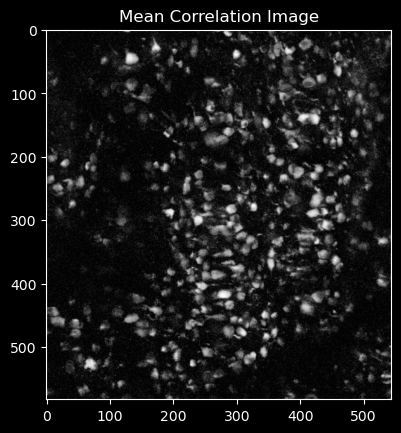

In [14]:
plt.imshow(corr, cmap='gray')
plt.title("Mean Correlation Image")
plt.show()

View an example movie

In [ ]:
from napari import Viewer
# create the viewer
viewer = Viewer()
# viewer.add_image(df.iloc[0].caiman.get_input_movie(), name='input', colormap='gray')
viewer.add_image(df.iloc[0].mcorr.get_output(), name='output', colormap='gray')

In [53]:
shifts = df.iloc[0].mcorr.get_shifts()
shifts2 = shifts[1]
shifts3=shifts2[:]
len(shifts3[:])

800

## Extras


In [ ]:

savep = parent / "tiff" 

savep.mkdir(exist_ok=True)

def sp(reader, plane):
    idx = plane - 1
    savename = savep / f"extracted_plane_{plane}_v1.tiff"
    print(savename)
    trim_x = trim(reader, (7,7))
    image_og = reader[1, idx, :,:]
    image_trim = reader[1, idx, trim_x, :]
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(image_og)
    ax[0].axis('off')
    ax[0].set_title('untrimmed')
    ax[1].imshow(image_trim)
    ax[1].axis('off')
    ax[1].set_title('trimmed')
    plt.show()

sp(reader, 1)